In [151]:
# # Setting up google drive 
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [152]:
import my_utils as mu
import torch
from torch import nn
import torchvision
import numpy as np

import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import sys
import tarfile
import time
import requests
import zipfile
import hashlib
d2l = sys.modules[__name__]


# Defined in file: ./chapter_preface/index.md
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

# The Task

* Our goal for this week is to write some code to create an MLP and then experiment with several training options and hyper-parameters.

* For this reason we will use again the same pipeline we used last week! 
    
* The Learning Outcome: Hands-on application of PyTorch's API for creating and training MLPs for classification.

In [153]:
# Read training and test data
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

In [154]:
# X,y = next(iter(train_iter))
# print(X.shape)

In [155]:
#X[0][0]

In [156]:
#patches = X.unfold(2, 14, 14).unfold(3, 14, 14)
#patches = patches.reshape(256, 1, -1, 7, 7)

#patches.shape
#patches[0]

In [157]:
def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)

In [158]:
#X.shape
#patches.shape
def patching(batch):
  final = []
  batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)
  for x in batch:
    p = x.flatten()
    p = torch.split(p,196)
    p = tuple_of_tensors_to_tensor(p)
    p.shape
    final.append(p)
  final = torch.stack(final)
  return final

#X2 = patching(X)
#X2.shape
#X2[0].mean(axis=1)

In [159]:
from PIL import Image

In [160]:
# tranposed = torch.transpose(X2,1,2)
# tranposed[0]

In [161]:
#X2[0]

In [162]:
# img_test = X2[0][1].numpy()
# print(img_test)
# img_test = np.array(img_test,dtype=np.uint8)
# img_test = img_test.reshape(14,14)
# img_test.shape

In [163]:
# img = Image.fromarray(img_test)
# img.save('img.jpg')
# img.show()

In [164]:
# lin = nn.Linear(196, 10, bias=False)
# testt = lin(X2)
# parameters = []
# for param in lin.parameters():
#   parameters.append(param)
# parameters = torch.stack(parameters)
# parameters

In [165]:
#testt

In [166]:
#torch.bmm(X2, parameters)

In [167]:
# len(patches[0].flatten())
# p2 = patches[0].flatten()
# p2 = torch.split(p2,196)
# p2 = tuple_of_tensors_to_tensor(p2)
# p2.shape

In [168]:
# from PIL import Image
# import numpy as np
# #Image.fromarray(torch.squeeze(patches[0][0]).detach().cpu().numpy())
# p= torch.squeeze(patches[1][0][0][0]).detach().cpu().numpy().astype(np.uint8) * 255
# print(np.min(p))
# print(np.max(p))
# Image.fromarray(p)

In [169]:
def tuple_of_tensors_to_tensor(tuple_of_tensors):
    return  torch.stack(list(tuple_of_tensors), dim=0)

In [170]:
def patching(batch):
    final = []
    batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)
    for x in batch:
        p = x.flatten()
        p = torch.split(p,196)
        p = tuple_of_tensors_to_tensor(p)
        p.shape
        final.append(p)
    final = torch.stack(final)
    return final

## Task 1


* The model below implements Softmax Regression. It has 1 Linear (or Fully-Connected Layer). Expand the `Net` class to have one more linear layer as follows: the 1st Linear layer will output `num_hidden` outputs. Set `num_hidden=10`.  Moreover, apply a `ReLU` activation function to the output of the 1st Linear layer. The second linear layer will have `num_hidden` inputs and 10 outputs (i.e. equal to the number of classes).



In [171]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs,num_inputs)
        self.relu1 = nn.ReLU()
        # self.Lineart1 = nn.Linear(4,20)
        # self.Lineart2 = nn.Linear(20,40)
        # self.Linear2 = nn.Linear(10,num_outputs)
        # self.Linear3 = nn.Linear(196,100)
        # self.Linear4 = nn.Linear(100,10)
        self.Linear2 = nn.Linear(4, 98)
        self.Linear3 = nn.Linear(98, 4)
        self.Linear4 = nn.Linear(196, 50)
        self.relu2 = nn.ReLU()
        self.Linear5 = nn.Linear(50, 50)
        self.LinearC = nn.Linear(50,10)
        
    
    def tuple_of_tensors_to_tensor(self,tuple_of_tensors):
        return  torch.stack(list(tuple_of_tensors), dim=0) 
    
    def patching(self,batch):
        final = []
        batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)
        for x in batch:
          p = x.flatten()
          p = torch.split(p,196)
          p = tuple_of_tensors_to_tensor(p)
          p.shape
          final.append(p)
        final = torch.stack(final)
        return final
    
    def forward(self, x):
        #STEM
        x = self.patching(x)
        out = self.Linear1(x)
        out = torch.transpose(out,1,2)
        out = self.Linear2(out)
        out = self.relu1(out)
        out = self.Linear3(out)
        out = torch.transpose(out,1,2)
        #print(out.shape)
        out = self.Linear4(out)
        out = self.relu2(out)
        out = self.Linear5(out)
        out = torch.mean(out,dim=1)
        out = self.LinearC(out)

        return out

In [172]:
# Model instantiation and initialisation 
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

In [173]:
# Create and initialize your model here:
num_inputs, num_outputs = 196,10
net = Net(num_inputs, num_outputs)

# Initialise your model here using init_weights function. If not done, default initiliazation will be used.
net.apply(init_weights)

Net(
  (Linear1): Linear(in_features=196, out_features=196, bias=True)
  (relu1): ReLU()
  (Linear2): Linear(in_features=4, out_features=98, bias=True)
  (Linear3): Linear(in_features=98, out_features=4, bias=True)
  (Linear4): Linear(in_features=196, out_features=50, bias=True)
  (relu2): ReLU()
  (Linear5): Linear(in_features=50, out_features=50, bias=True)
  (LinearC): Linear(in_features=50, out_features=10, bias=True)
)

# Loss and Optimization Algorithm
* As in Softmax Regression.

In [174]:
# Creare your loss here. Use Cross Entropy loss:
loss = nn.CrossEntropyLoss()
lr, wd = 0.1, 0.0005
# Creare your optimizer here. Use SGD with weight decay wd and learning rate lr.
optimizer = torch.optim.Adam(net.parameters(),weight_decay=wd,lr=lr)

# Training

* Use `my_utils.train_ch3` as in Softmax Regression

RuntimeError: DataLoader worker (pid(s) 620, 8548, 18764, 27388) exited unexpectedly

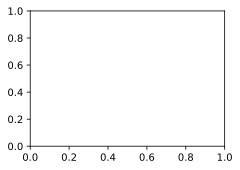

In [175]:
num_epochs = 10
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs,optimizer)

## Further Tasks

* Explore the following training options and observe their impact on the evolution of the **training loss**, the **training accuracy** and the **validation accuracy**. Different choices might have different impact on both accuracy and convergence:
    1. Change the number of hidden layers to 256
    1. Investigate different learning rates. Use 0.5, 0.9 and 0.01.
    1. Investigate adding weight decay wd=0.0005
    1. Investigate `Sigmoid` activation function. 
    1. Try different schemes for initializing the weights. 